## **EN4573 Assignment 01: Linear models for regression**

Name - Akila Rajapaksha \
Index No. - 190484T \
Data - 04/03/2024

## **Question 3 - Linear Regression on Real-World Data**

In [1]:
import os, sys

import numpy as np
import pandas as pd

### **Loading the Dataset**

In [94]:
# load the dataset from housing.csv file
file_path = 'housing.csv'

df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### **Extract the Input Features and the Target Data**

- Notice that there is a total of $2930$ datapoints. 

In [95]:
# extract the input features
features = ['Lot Area', 'Garage Yr Blt', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Pool Area']
X = df[features]
X

,Lot Area,Garage Yr Blt,Bedroom AbvGr,Kitchen AbvGr,Pool Area
0,31770,1960.0,3,1,0
1,11622,1961.0,2,1,0
2,14267,1958.0,3,1,0
3,11160,1968.0,3,1,0
4,13830,1997.0,3,1,0
...,...,...,...,...,...
2925,7937,1984.0,3,1,0
2926,8885,1983.0,2,1,0
2927,10441,NaN,3,1,0
2928,10010,1975.0,2,1,0


In [22]:
# extract the target
y = df[['SalePrice']]
y

,SalePrice
0,215000
1,105000
2,172000
3,244000
4,189900
...,...
2925,142500
2926,131000
2927,132000
2928,170000


### **Pre-processing Data**

- As described in the report, before applying linear regression on the extracted data, we must prepare (pre-process) the data accordingly. 
- Let's discuss and implement each of the pre-processing steps seperately below.   

#### 1. *Encoding Categorical Variables*

- All the five features mentioned in the assignment are numerical features, and there are no categorical features to convert into numerical values. 

#### 2. *Handling Missing Values*

- Firstly, we have to check whether there are missing entries in the extracted data. 

In [16]:
# find the missing entries in each feature
(X.isna()).sum()

Lot Area           0
Garage Yr Blt    159
Bedroom AbvGr      0
Kitchen AbvGr      0
Pool Area          0
dtype: int64

- As you can see in the above result, there are $159$ missing values out of the total $2930$ entries in the `Garage Yr Blt` feature. 
- Let's use **mean imputation** to fill in the missing entries with the mean value of the existing feature values. 

In [24]:
# perform mean imputation
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy='mean')
imputed_X = mean_imputer.fit_transform(X)
imputed_X = pd.DataFrame(imputed_X, columns=X.columns)

- There are no missing values in the target variable as shown below. 

In [74]:
# find the missing values in the target values
(y.isna()).sum()

SalePrice    0
dtype: int64

#### 3. *Handling Outliers*

- The dataset may contain outliers, and if there are, then we have to handle them appropriately to perform model training. 
- *To identify possible outliers, we have to visualize the data.* 


- A more convenient way of data representation for outlier detection is using **scatterplots**. 

**Scatter Plots**

- One can take a better visual representation of the data distribution using scatterplots which plot the target variable values with respect to a selected input feature.
- Here, I have created scatterplots for each input feature using the Python package `seaborn`. 

<Axes: xlabel='Lot Area', ylabel='SalePrice'>

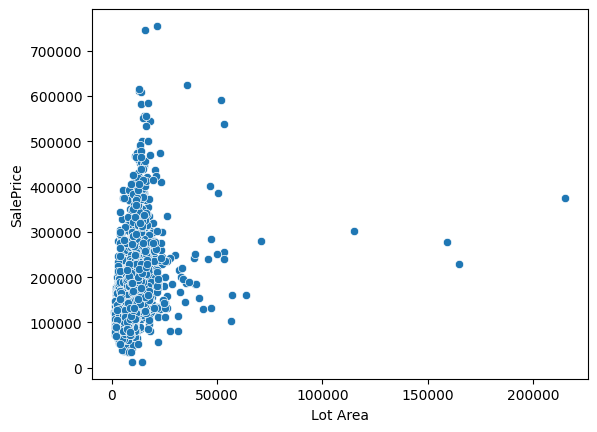

In [123]:
import seaborn as sns
sns.scatterplot(imputed_X, x='Lot Area', y=y['SalePrice'])

<Axes: xlabel='Garage Yr Blt', ylabel='SalePrice'>

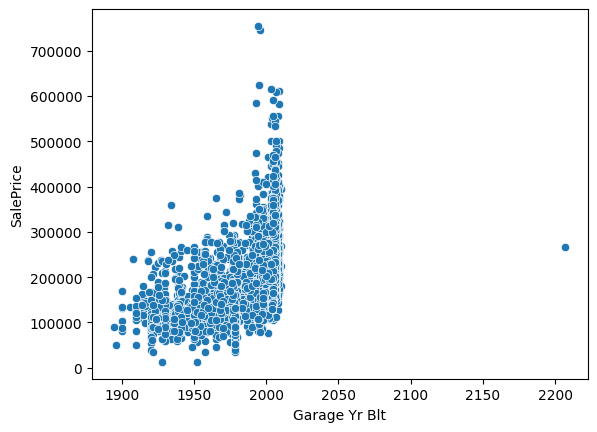

In [124]:
sns.scatterplot(imputed_X, x='Garage Yr Blt', y=y['SalePrice'])

<Axes: xlabel='Bedroom AbvGr', ylabel='SalePrice'>

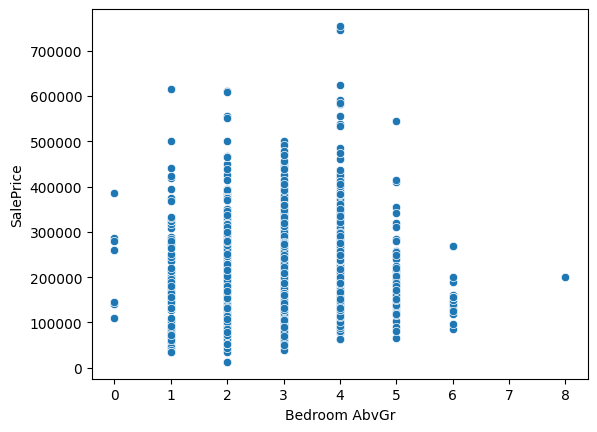

In [125]:
sns.scatterplot(imputed_X, x='Bedroom AbvGr', y=y['SalePrice'])

<Axes: xlabel='Kitchen AbvGr', ylabel='SalePrice'>

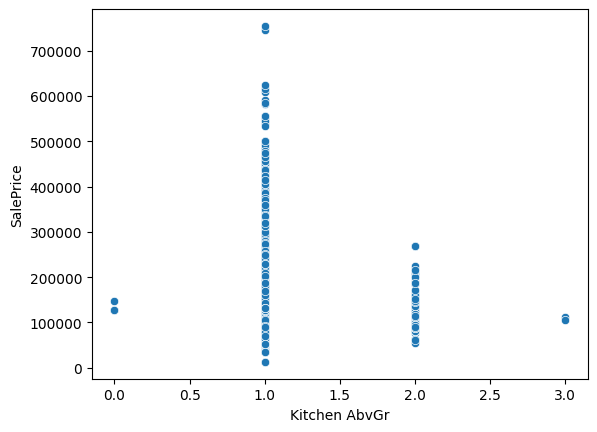

In [126]:
sns.scatterplot(imputed_X, x='Kitchen AbvGr', y=y['SalePrice'])

<Axes: xlabel='Pool Area', ylabel='SalePrice'>

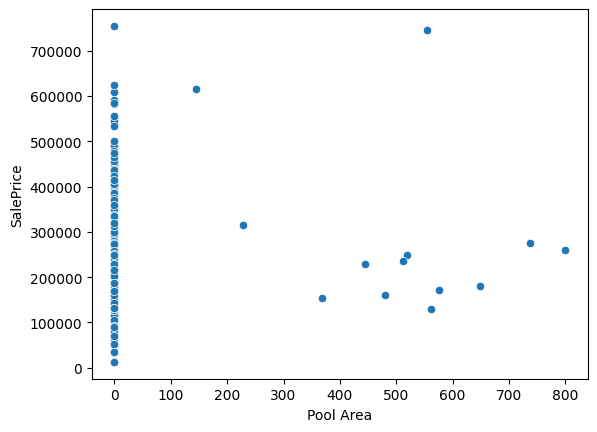

In [127]:
sns.scatterplot(imputed_X, x='Pool Area', y=y['SalePrice'])

- In the above 2D presentations of features, we can clearly observe that the datapoints having a `Lot Area` value greater than $100,000$ or a `Garage Yr Blt` value greater than $2050$ deviate significantly from the main cluster of data and hence can be identified as outliers. 
- Therefore, we can outline following maximum thresholds for each feature, so once surpassed, the datapoints are considered to be outliers. 
    - $maximum\ Lot\ Area\ Threshold = 100,000$
    - $maximum\ Garage\ Yr \ Blt\ Threshold = 2,050$
- With these thresholds, there are a total of $5$ outliers in the extracted dataset. 

In [60]:
max_Lot_Area_thresh = 100_000
max_Garage_Yr_Blt_thresh = 2_050

**Handling Oultiers**

- There are various techniques to handle outliers in a dataset, such as *removing outliers*, *transform data to minimize the impact of outliers*, or *applying robust regression techniques*. 
- In this case, we will implement removing outliers since we have only $5$ outlier datapoints and getting rid of them is unlikely to cause a consdierable loss of valuable information. 

In [84]:
# finding the outlier indices
outlier_indices = []
Lot_Area_outliers = imputed_X[imputed_X['Lot Area'] > max_Lot_Area_thresh].index
Garage_Yr_Belt_outliers = imputed_X[imputed_X['Garage Yr Blt'] > max_Garage_Yr_Blt_thresh].index

print(f"outlier indices for feature 'Lot Area': {list(Lot_Area_outliers)}")
print(f"outlier indices for feature 'Garage Yr Blt': {list(Garage_Yr_Belt_outliers)}")

outlier_indices.extend(Lot_Area_outliers)
outlier_indices.extend(Garage_Yr_Belt_outliers)
outlier_indices = list(set(outlier_indices))

outlier indices for feature 'Lot Area': [956, 1570, 2071, 2115]
outlier indices for feature 'Garage Yr Blt': [2260]


In [83]:
# removing the identified outliers from input features
cleaned_X = imputed_X.drop(outlier_indices)

cleaned_X.reset_index(drop=True, inplace=True)

In [105]:
# removing the identified outliers from the target variable
cleaned_y = y.drop(outlier_indices)
cleaned_y.reset_index(drop=True, inplace=True)

In [85]:
cleaned_X

,Lot Area,Garage Yr Blt,Bedroom AbvGr,Kitchen AbvGr,Pool Area
0,31770.0,1960.000000,3.0,1.0,0.0
1,11622.0,1961.000000,2.0,1.0,0.0
2,14267.0,1958.000000,3.0,1.0,0.0
3,11160.0,1968.000000,3.0,1.0,0.0
4,13830.0,1997.000000,3.0,1.0,0.0
...,...,...,...,...,...
2920,7937.0,1984.000000,3.0,1.0,0.0
2921,8885.0,1983.000000,2.0,1.0,0.0
2922,10441.0,1978.132443,3.0,1.0,0.0
2923,10010.0,1975.000000,2.0,1.0,0.0


In [106]:
cleaned_y

,SalePrice
0,215000
1,105000
2,172000
3,244000
4,189900
...,...
2920,142500
2921,131000
2922,132000
2923,170000


- Now, by visualizing the first two features using a scatterplot with the cleared input data, we can verify that the outliers have been removed. 

<Axes: xlabel='Lot Area', ylabel='Garage Yr Blt'>

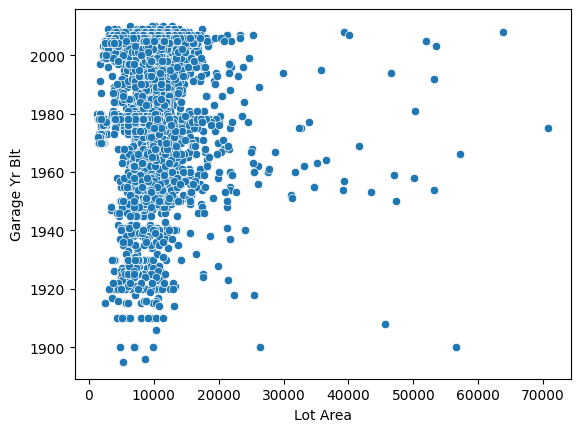

In [87]:
# recreating the scatter plot
sns.scatterplot(cleaned_X, x='Lot Area', y='Garage Yr Blt')

#### 4. *Feature Scaling*

- Now, it is time to perform feature scaling as discussed in the report and to bring all the feature values to a similar value range. 
- There are a variety of ways to scale features in a dataset, including Standardization and other Normalization techniques like Min-Max Scaler and Max-Abs Scaler. 
- Here, we will use **Standardization** to scale data. 

In [92]:
# perform feature scaling using standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X = cleaned_X.copy()
scaled_X[features] = scaler.fit_transform(cleaned_X[features])

scaled_X

,Lot Area,Garage Yr Blt,Bedroom AbvGr,Kitchen AbvGr,Pool Area
0,4.107613,-0.738435,0.175955,-0.207476,-0.063085
1,0.316696,-0.697575,-1.032189,-0.207476,-0.063085
2,0.814362,-0.820154,0.175955,-0.207476,-0.063085
3,0.229769,-0.411558,0.175955,-0.207476,-0.063085
4,0.732139,0.773370,0.175955,-0.207476,-0.063085
...,...,...,...,...,...
2920,-0.376650,0.242195,0.175955,-0.207476,-0.063085
2921,-0.198281,0.201336,-1.032189,-0.207476,-0.063085
2922,0.094486,0.002449,0.175955,-0.207476,-0.063085
2923,0.013392,-0.125541,-1.032189,-0.207476,-0.063085


<Axes: xlabel='Lot Area', ylabel='Count'>

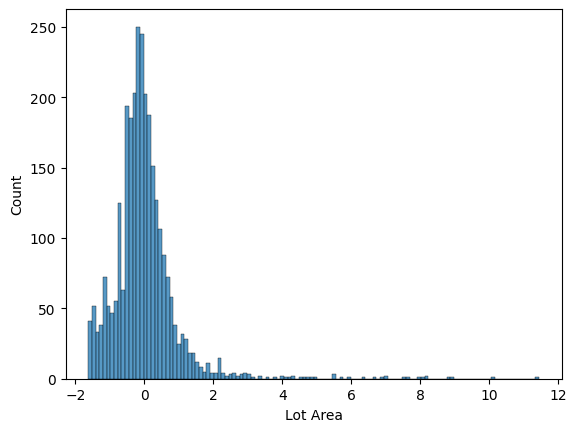

In [98]:
sns.histplot(data=scaled_X, x='Lot Area')

<Axes: xlabel='Garage Yr Blt', ylabel='Count'>

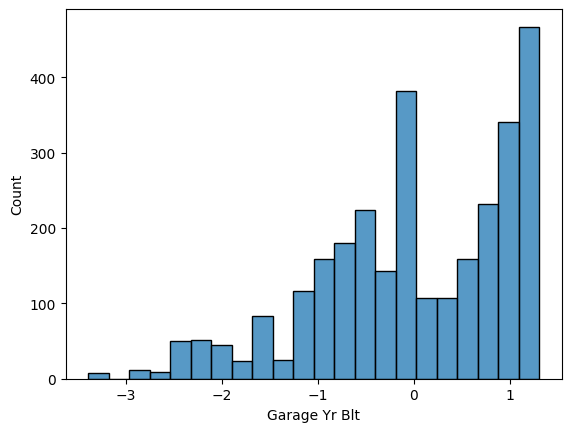

In [99]:
sns.histplot(data=scaled_X, x='Garage Yr Blt')

<Axes: xlabel='Bedroom AbvGr', ylabel='Count'>

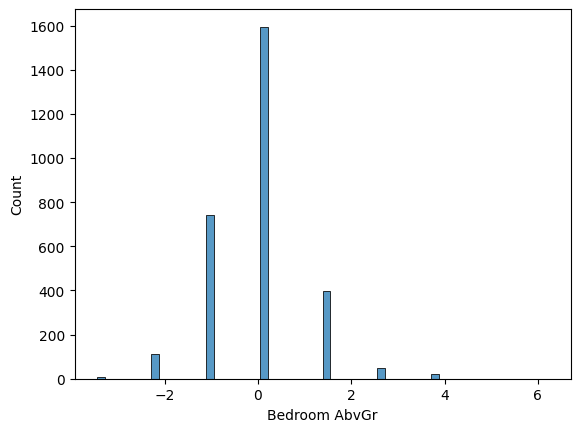

In [100]:
sns.histplot(data=scaled_X, x='Bedroom AbvGr')

<Axes: xlabel='Kitchen AbvGr', ylabel='Count'>

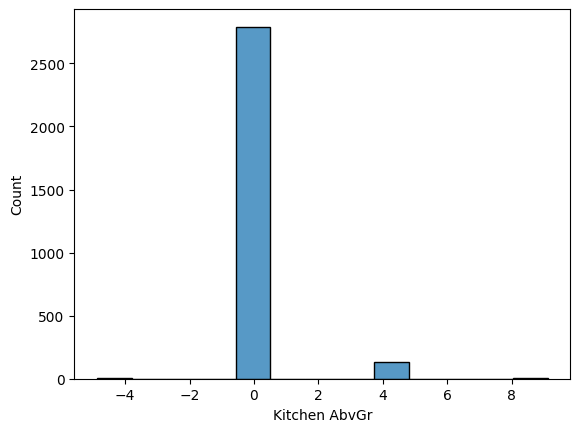

In [101]:
sns.histplot(data=scaled_X, x='Kitchen AbvGr')

<Axes: xlabel='Pool Area', ylabel='Count'>

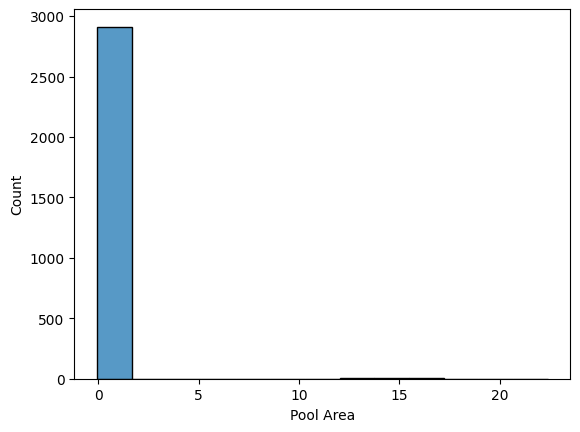

In [102]:
sns.histplot(data=scaled_X, x='Pool Area')

<Axes: xlabel='Lot Area', ylabel='Garage Yr Blt'>

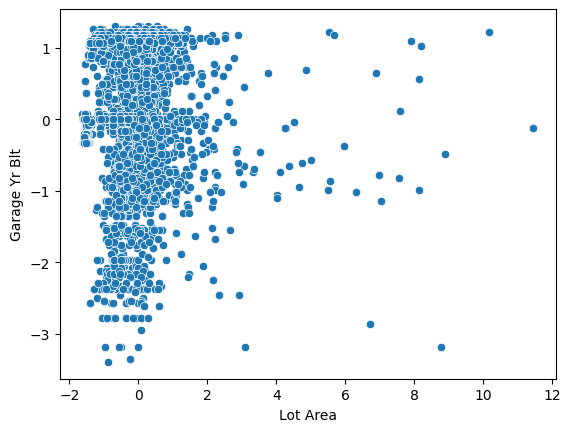

In [103]:
sns.scatterplot(data=scaled_X, x='Lot Area', y='Garage Yr Blt')

#### 5. *Feature Selection/Dimensionality Reduction*

- This pre-processing step doesn't apply here since the problem specifically mention to use all the five features to train a model. 
- Removing features can be done later after a Linear Regression model is trained and the p-values of the features are evaluated. 

### **Splitting the Data into Train and Test Sets**

- Once the data is completely pre-processed, the datapoints have to be divided into train and test datasets. 
- As mentioned in the question, we will seperate $80\%$ of datapoints for training and $20\%$ datapoints for testing. 

In [107]:
# splitting the dataset
from sklearn.model_selection import train_test_split

# use a fixed random seed (`random_state`) to make the split reproducible
X_train, X_test, y_train, y_test = train_test_split(scaled_X, cleaned_y, test_size=0.20, random_state=1)

In [132]:
X_test

,Lot Area,Garage Yr Blt,Bedroom AbvGr,Kitchen AbvGr,Pool Area
1117,-0.096113,1.181965,0.175955,-0.207476,-0.063085
192,-0.403744,-2.045941,0.175955,-0.207476,-0.063085
2190,0.180096,0.002449,6.216676,4.460737,-0.063085
45,-0.671299,1.304544,-1.032189,-0.207476,-0.063085
2473,-0.524162,0.569072,0.175955,-0.207476,-0.063085
...,...,...,...,...,...
2287,-0.152371,-0.043822,-2.240333,-0.207476,-0.063085
1525,1.058397,0.650791,0.175955,-0.207476,-0.063085
1517,-0.289535,-2.168520,1.384099,-0.207476,-0.063085
1351,-0.154065,-2.168520,1.384099,-0.207476,-0.063085


### **Training a Linear Regression Model**

- Now, it is time to train a linear regression model. 
- Here, we use the class `sklearn.linear_model.LinearRegression` for model training, and it inherently uses **Ordinary Least Squares (OLS)** to perform linear regression. 

In [110]:
# train a model
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [117]:
# summarize the trained model 
print(f"model coefficients ")
for i in range(model.n_features_in_):
    print(f"\t{model.feature_names_in_[i]}: {model.coef_[0][i]}")

print(f"\nmodel intercept: {model.intercept_[0]}")

model coefficients 
	Lot Area: 25094.79736084246
	Garage Yr Blt: 40425.325662951705
	Bedroom AbvGr: 9869.272438440152
	Kitchen AbvGr: -7741.930774457944
	Pool Area: 1020.3176130727443

model intercept: 181015.26929298483


### **Testing the Model**

- Finally, we have to evaluate the trained model. 
- There are a number of metrics to evaluate a model's performance, such as **Sum of Squared Error (SSE)/Residual Sum of Squares (RSS)**, **Mean Sqaured Error (MSE)**, **Root Mean Squared Error (RMSE)**, **Residual Standard Error (RSE)**, and **$R^2$ Statistic**. 
- Here, **we will measure MSE, RMSE, and $R^2$ statistic value**. 

In [161]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

# get the model predictions for the test data
y_pred = model.predict(X_test)

MSE = mean_squared_error(y_true=y_test, y_pred=y_pred)
RMSE = root_mean_squared_error(y_true=y_test, y_pred=y_pred)
R2_statistic = r2_score(y_true=y_test, y_pred=y_pred)

print(f"mean squared error (MSE): {MSE}")
print(f"root mean squared error (RMSE): {RMSE}")
print(f"R2 statistic for the trained model: {R2_statistic}")

mean squared error (MSE): 4643328949.2881365
root mean squared error (RMSE): 68141.97641166666
R2 statistic for the trained model: 0.3486137054074828


- We get a value of $0.3486$ for the $R^2$ statistic of the trained model, which can be interpreted as the linear regression model explains approximately $34.8\%$ of the variance in the target variable. 
- However, this value for $R^2$ metric is not in an acceptable level, as a well-trained model takes an $R^2$ value closer to $1$ ($R^2 \in [0, 1]$). 

- As an analysis, we will plot the scatter plots showing true and predicted target values considering each feature. 
- Notice the non-linear and noisy behavior of the true datapoints.

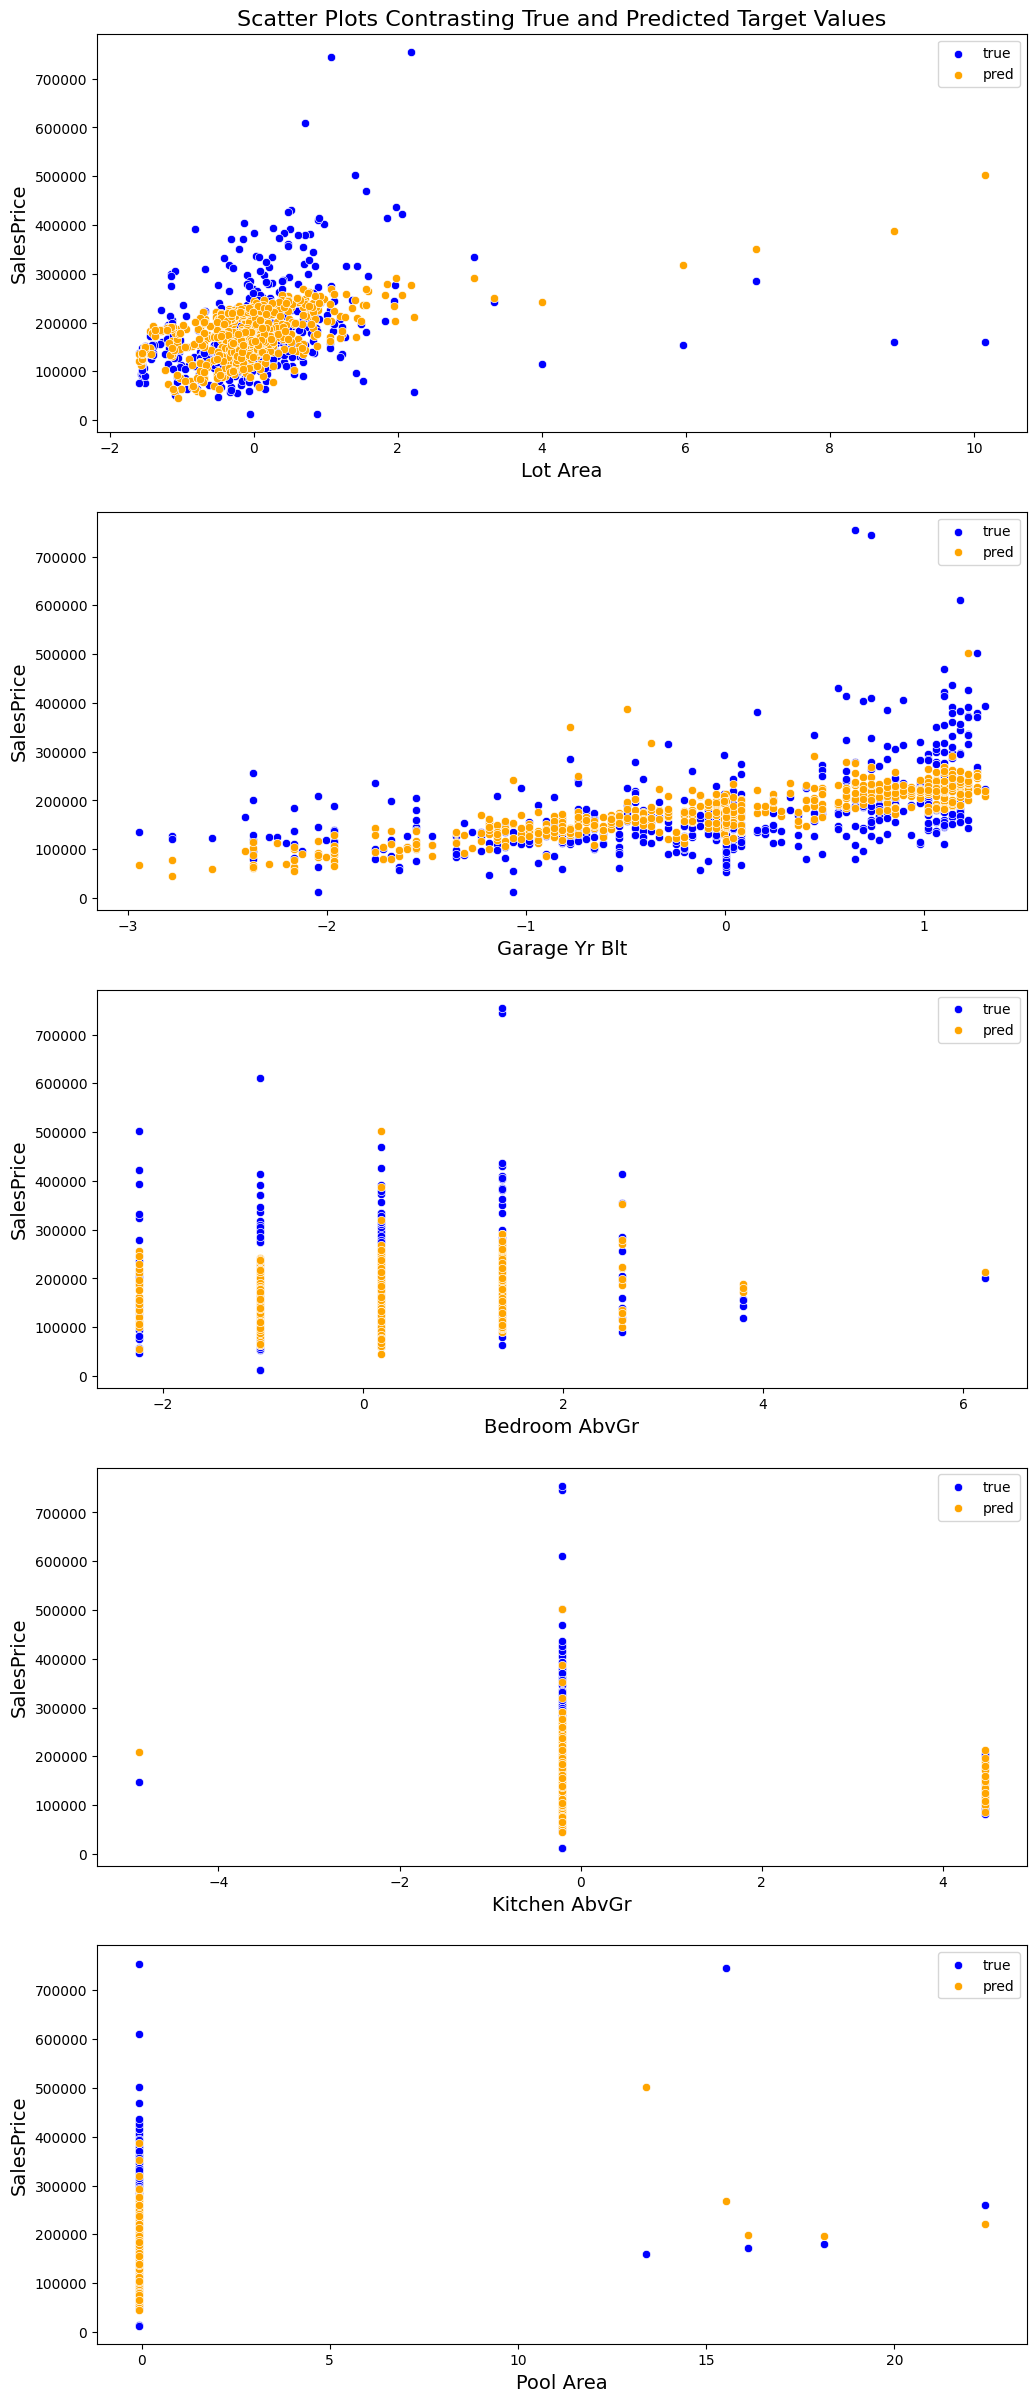

In [163]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=len(features), figsize=(12, 6*len(features)))

ax[0].set_title("Scatter Plots Contrasting True and Predicted Target Values", fontsize=16)
for i in range(len(features)):
    sns.scatterplot(data=X_test, x=features[i], y=y_test['SalePrice'], ax=ax[i], color='blue', label="true")
    sns.scatterplot(data=X_test, x=features[i], y=y_pred.T[0], ax=ax[i], color='orange', label='pred')
    ax[i].set_xlabel(features[i], fontsize=14)
    ax[i].set_ylabel("SalesPrice", fontsize=14)
    ax[i].legend()

### **Trying Robust Regression Techniques**

- Let's try **Ridge Regression** to improve the model's performance

In [159]:
from sklearn.linear_model import Ridge

alphas = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1_000]

print("Ridge Regression")
for i, alpha in enumerate(alphas):
    
    ridge_model = Ridge(alpha=alpha)

    ridge_model.fit(X_train, y_train)

    y_pred_ridge = ridge_model.predict(X_test)

    R2_statistic = r2_score(y_true=y_test, y_pred=y_pred_ridge)

    print(f"\tfor alpha={alpha}: R2 statistic: {R2_statistic}")

Ridge Regression
	for alpha=0.001: R2 statistic: 0.3486137067404731
	for alpha=0.01: R2 statistic: 0.34861371873201175
	for alpha=0.1: R2 statistic: 0.3486138381153421
	for alpha=1: R2 statistic: 0.3486149787866605
	for alpha=10: R2 statistic: 0.3486211126073776
	for alpha=100: R2 statistic: 0.34819591020440255
	for alpha=1000: R2 statistic: 0.31981692769111925


In [160]:
from sklearn.linear_model import Lasso

alphas = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1_000]

print("Lasso Regression")
for i, alpha in enumerate(alphas):
    
    lasso_model = Lasso(alpha=alpha)

    lasso_model.fit(X_train, y_train)

    y_pred_lasso = lasso_model.predict(X_test)

    R2_statistic = r2_score(y_true=y_test, y_pred=y_pred_lasso)

    print(f"\tfor alpha={alpha}: R2 statistic: {R2_statistic}")

Lasso Regression
	for alpha=0.001: R2 statistic: 0.34861370239233935
	for alpha=0.01: R2 statistic: 0.3486136751841181
	for alpha=0.1: R2 statistic: 0.3486134022920375
	for alpha=1: R2 statistic: 0.3486106628651401
	for alpha=10: R2 statistic: 0.3485830416902087
	for alpha=100: R2 statistic: 0.3482997340408224
	for alpha=1000: R2 statistic: 0.34545492659868793


### **Calculating P Values for each feature**

- Here, we use the Python package `statsmodels`. 

In [166]:
import statsmodels.api as sm

# Add a constant column to the features matrix for the intercept term
X_with_intercept = sm.add_constant(X_train)

# Fit a linear regression model using statsmodels
model_sm = sm.OLS(y_train, X_with_intercept).fit()

# Get the p-values for each feature
p_values = model_sm.pvalues

# Print the p-values for each feature
print("P-values for each feature:")
print(p_values)

# Optionally, you can discard features with p-values above a certain threshold
threshold = 0.05  # Example threshold (adjust as needed)
discarded_features = p_values[p_values > threshold].index.tolist()
print("\nFeatures to be discarded:", discarded_features)


P-values for each feature:
const             0.000000e+00
Lot Area          1.866456e-79
Garage Yr Blt    4.838504e-191
Bedroom AbvGr     8.261553e-14
Kitchen AbvGr     8.889874e-10
Pool Area         5.292181e-01
dtype: float64

Features to be discarded: ['Pool Area']
